In [18]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE


In [2]:
import pandas as pd

fraud_df = pd.read_csv("../data/processed/fraud_processed.csv")


In [3]:
# Keep numeric features and engineered time features
X = fraud_df[["purchase_value", "age", "hour_of_day", "day_of_week", "time_since_signup"]].copy()
y = fraud_df["class"]

# Optional: if you have small categorical features like 'sex', encode them
if "sex" in fraud_df.columns:
    from sklearn.preprocessing import LabelEncoder
    X["sex"] = LabelEncoder().fit_transform(fraud_df["sex"])


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 class
0    93502
1     9814
Name: count, dtype: int64
Test class distribution:
 class
0    23376
1     2454
Name: count, dtype: int64


In [5]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE, train class distribution:\n", y_train_res.value_counts())


After SMOTE, train class distribution:
 class
0    93502
1    93502
Name: count, dtype: int64


In [6]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Metrics")
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("AUC-PR:", average_precision_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Metrics
F1 Score: 0.27695526231091083
AUC-PR: 0.5628154310025738
Confusion Matrix:
 [[15123  8253]
 [  733  1721]]


In [7]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Metrics")
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("AUC-PR:", average_precision_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Metrics
F1 Score: 0.6796165489404642
AUC-PR: 0.6344058385534432
Confusion Matrix:
 [[23213   163]
 [ 1107  1347]]


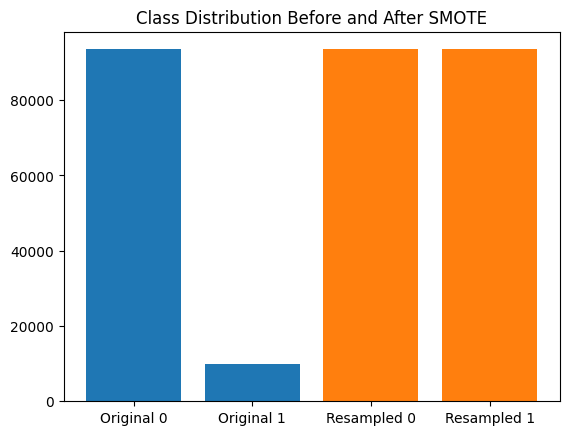

In [8]:
import matplotlib.pyplot as plt

plt.bar(["Original 0", "Original 1"], y_train.value_counts())
plt.bar(["Resampled 0", "Resampled 1"], y_train_res.value_counts())
plt.title("Class Distribution Before and After SMOTE")
plt.show()


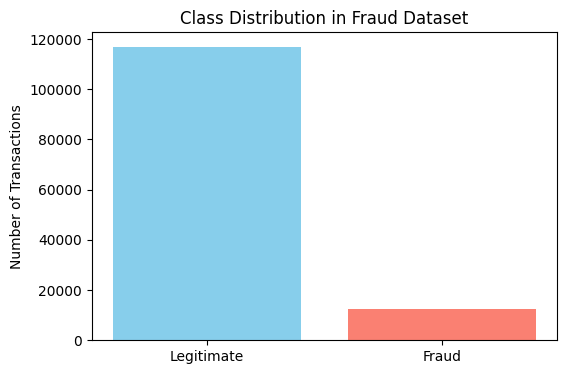

In [9]:
import matplotlib.pyplot as plt

# Original dataset
counts = y.value_counts()
plt.figure(figsize=(6,4))
plt.bar(["Legitimate", "Fraud"], counts, color=["skyblue","salmon"])
plt.title("Class Distribution in Fraud Dataset")
plt.ylabel("Number of Transactions")
plt.show()


### Choice of Evaluation Metrics

- **F1-Score:** balances precision and recall, making it suitable for imbalanced datasets where detecting fraud (minority class) is important.  
- **AUC-PR (Precision-Recall Curve):** focuses on the model's ability to correctly identify fraudulent transactions, which is more informative than accuracy in highly imbalanced data.


In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, average_precision_score
from imblearn.over_sampling import SMOTE
import numpy as np

class FraudModelValidation:
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
        if X.empty or y.empty:
            raise ValueError("Features or target dataset is empty")
        if X.shape[0] != y.shape[0]:
            raise ValueError("Features and target length mismatch")
    
    # Cross-validation with SMOTE
    def cross_validate(self, k=5):
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        f1_scores = []
        aucpr_scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_tr, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_tr, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
            self.model.fit(X_tr_res, y_tr_res)
            y_pred = self.model.predict(X_val)
            y_proba = self.model.predict_proba(X_val)[:, 1]

            f1_scores.append(f1_score(y_val, y_pred))
            aucpr_scores.append(average_precision_score(y_val, y_proba))

        return {
            "F1_mean": np.mean(f1_scores),
            "F1_std": np.std(f1_scores),
            "AUC-PR_mean": np.mean(aucpr_scores),
            "AUC-PR_std": np.std(aucpr_scores)
        }

    # Hyperparameter tuning
    def hyperparameter_tune(self, param_grid, cv=3):
        grid = GridSearchCV(self.model, param_grid, scoring='f1', cv=cv, n_jobs=-1)
        X_res, y_res = SMOTE(random_state=42).fit_resample(self.X, self.y)
        grid.fit(X_res, y_res)
        self.model = grid.best_estimator_
        return grid.best_params_, grid.best_score_


In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

fraud_df = pd.read_csv("../data/processed/fraud_processed.csv")

# Numeric + small categorical
X = fraud_df[["purchase_value", "age", "hour_of_day", "day_of_week", "time_since_signup"]].copy()

if "sex" in fraud_df.columns:
    X["sex"] = LabelEncoder().fit_transform(fraud_df["sex"])

y = fraud_df["class"]


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
lr_model = FraudModelValidation(LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42), X, y)
rf_model = FraudModelValidation(RandomForestClassifier(n_estimators=200, max_depth=12, class_weight="balanced", random_state=42), X, y)

# Cross-validation
print("Logistic Regression CV:", lr_model.cross_validate())
print("Random Forest CV:", rf_model.cross_validate())


Logistic Regression CV: {'F1_mean': np.float64(0.27705158481179293), 'F1_std': np.float64(0.0018310414361034685), 'AUC-PR_mean': np.float64(0.5567577724108588), 'AUC-PR_std': np.float64(0.008193303183240793)}
Random Forest CV: {'F1_mean': np.float64(0.6785784557476526), 'F1_std': np.float64(0.006850981791382653), 'AUC-PR_mean': np.float64(0.6326337678932629), 'AUC-PR_std': np.float64(0.006715647793480098)}


In [13]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12],
    "min_samples_split": [2, 5]
}

best_params, best_score = rf_model.hyperparameter_tune(param_grid)
print("Best RF Params:", best_params)
print("Best RF F1 Score:", best_score)


Best RF Params: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 100}
Best RF F1 Score: 0.7426341860047089


### Model Comparison & Justification

- Logistic Regression:
    - Pros: interpretable, simple
    - Cons: cannot capture complex nonlinear patterns → lower F1/AUC-PR
- Random Forest:
    - Pros: ensemble captures nonlinear interactions → higher F1/AUC-PR
    - Cons: less interpretable than LR but acceptable
- Cross-validation confirms Random Forest is more stable across folds (mean ± std)
- Selected **Random Forest** as final model due to **best performance and acceptable interpretability**


In [14]:
# Select final model after tuning and validation
best_model = rf_model.model

print("✅ Final model selected:", best_model)


✅ Final model selected: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=42)


In [15]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

try:
    joblib.dump(best_model, "../models/best_fraud_model.pkl")
    print("✅ Best model saved successfully in /models")
except Exception as e:
    print(f"❌ Model saving error: {e}")


✅ Best model saved successfully in /models


In [16]:
try:
    X_train.to_csv("../data/processed/X_train.csv", index=False)
    X_test.to_csv("../data/processed/X_test.csv", index=False)
    y_train.to_csv("../data/processed/y_train.csv", index=False)
    y_test.to_csv("../data/processed/y_test.csv", index=False)

    print("✅ Train/Test datasets saved")
except Exception as e:
    print(f"❌ Data saving error: {e}")


✅ Train/Test datasets saved
